Jupiter Notebook Deep Learning Models 

In [164]:
""" ------------------ Machine Learning Models for ECG classification on PTB-XL, available @ https://physionet.org/content/ptb-xl/1.0.3/ -----------------------

Dataset: 21799 clinical 12-lead ECG records from 18869 patients
Length: 10 seconds length
Gender: 52% male 48% female
Ages:  0 - 95 years

Labels
9514	NORM    Normal ECG
5469	MI	    Myocardial Infarction
5235	STTC	ST/T Change
4898	CD	    Conduction Disturbance
2649	HYP	    Hypertrophy

12 Leads: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

"""

import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from ecg_data_handler import ECGDataHandler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, concatenate, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from tcn import TCN 

PATH_TO_12LEAD_ECG_DATA = r"C:\12lead_ECG_Dataset\\"
PATH_TO_DEMOGRAPHIC_CSV = r"C:\12lead_ECG_Dataset\ptbxl_database.csv"
PATH_TO_ANNOTATIONS = r"C:\12lead_ECG_Dataset\scp_statements.csv"
SAMPLING_RATE_100 = 100
SAMPLING_RATE_500 = 500
TIMESTEPS_1000 = 1000  
TIMESTEPS_5000 = 5000 
TRAIN_TEST_SPLIT = 0.2
INPUT_SHAPE_100hz = (1000, 12) 
INPUT_SHAPE_500hz = (5000, 12)
MODEL_EPOCHS_15 = 15
MODEL_EPOCHS_50 = 50
MODEL_EPOCHS_100 = 100
MODEL_EPOCHS_150 = 150
MODEL_EPOCHS_150 = 200
ECG_CHANNELS_12 = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ECG_CHANNELS_1_to_3 = ['I', 'II', 'III']
ECG_CHANNELS_a = ['aVR', 'aVL', 'aVF']
ECG_CHANNELS_V = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [42]:
#load X and Y data
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

Y = pd.read_csv(PATH_TO_DEMOGRAPHIC_CSV, index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X_100 = load_raw_data(Y, SAMPLING_RATE_100, PATH_TO_12LEAD_ECG_DATA)
X_500 = load_raw_data(Y, SAMPLING_RATE_500, PATH_TO_12LEAD_ECG_DATA)

agg_df = pd.read_csv(PATH_TO_ANNOTATIONS, index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [72]:
# reduce to ecg_id and diagnostic_superclass
def reduce_to_ecg_id_and_superclass(Y):
    
    if 'diagnostic_superclass' in Y.columns:
        result = Y[['diagnostic_superclass']].copy()
    else:
        raise ValueError("'diagnostic_superclass' does not exist")
    return result
Y_labeled = reduce_to_ecg_id_and_superclass(Y)


In [47]:
#checking shapes and plot ecg signal
print(X_100.shape)
print(X_500.shape)
print(Y_labeled.shape)

(21799, 1000, 12)
(21799, 5000, 12)
(21799, 1)


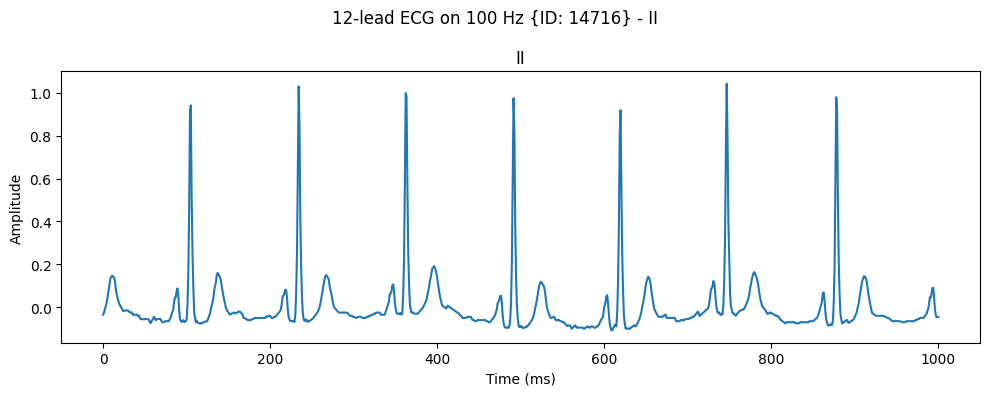

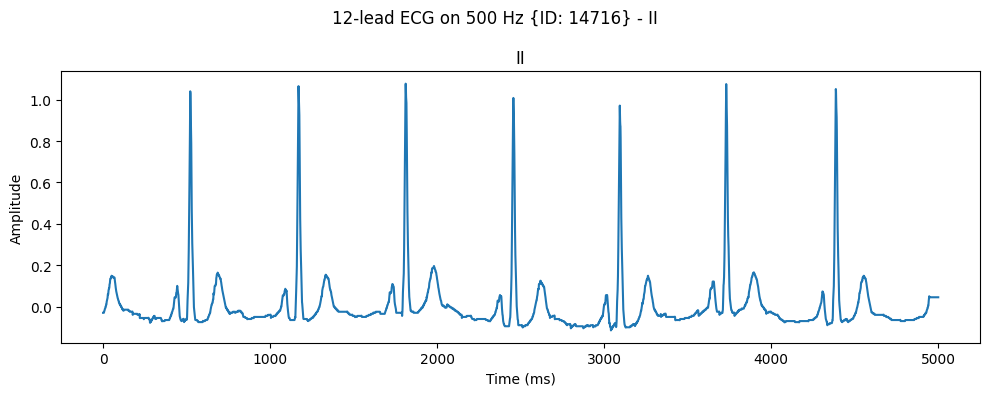

In [70]:
#plotting ECG signal single channel can be specified [None, 0-11]
single_channel = None
def plot_ecg(data, ecg_id, channels, timesteps, title="ECG", single_channel=single_channel):

    ecg = data[ecg_id - 1]
    time = np.linspace(0, timesteps, num=ecg.shape[0])
    
    if single_channel is None:
        fig, axs = plt.subplots(len(channels), 1, figsize=(10, 15), sharex=True)
        fig.suptitle(title)
        
        for i, channel in enumerate(channels):
            axs[i].plot(time, ecg[:, i])
            axs[i].set_title(channel)
            axs[i].set_ylabel('Amplitude')
    else:
        fig, ax = plt.subplots(figsize=(10, 4))
        fig.suptitle(f"{title} - {channels[single_channel]}")
        ax.plot(time, ecg[:, single_channel])
        ax.set_title(channels[single_channel])
        ax.set_ylabel('Amplitude')
        ax.set_xlabel('Time (ms)')
    
    plt.tight_layout()
    plt.show()

ecg_id = np.random.randint(1, 21799)
plot_ecg(X_100, ecg_id, ECG_CHANNELS_12, TIMESTEPS_1000, title="12-lead ECG on 100 Hz {ID: " + str(ecg_id) + "}")
plot_ecg(X_500, ecg_id, ECG_CHANNELS_12, TIMESTEPS_5000, title="12-lead ECG on 500 Hz {ID: " + str(ecg_id) + "}")

In [80]:
def check_unique_diagnostic_superclasses(Y_labeled):
    unique_labels = set()
    for labels_list in Y_labeled['diagnostic_superclass']:
        unique_labels.update(labels_list)
    return unique_labels
unique_superclasses = check_unique_diagnostic_superclasses(Y_labeled)
print("diagnostics superclasses:", unique_superclasses)

diagnostics superclasses: {'CD', 'STTC', 'HYP', 'MI', 'NORM'}


In [132]:
def create_subframe(Y_labeled, subclass_name):

    Y_subclass = Y_labeled[Y_labeled['diagnostic_superclass'].apply(lambda x: subclass_name in x)]
    return Y_subclass

Y_NORMAL = create_subframe(Y_labeled, 'NORM') # Normal ECG
Y_MI = create_subframe(Y_labeled, 'MI') # Myocardial Infarction
Y_STTC = create_subframe(Y_labeled, 'STTC') # ST/T Change
Y_CD = create_subframe(Y_labeled, 'CD') # Conduction Disturbance
Y_HYP = create_subframe(Y_labeled, 'HYP') # Hypertrophy
Y_UNNORMAL = pd.concat([Y_MI, Y_STTC, Y_CD, Y_HYP])
Y_UNNORMAL = Y_UNNORMAL.sort_values(by='ecg_id')
print("Y_NORMAL ", Y_NORMAL.shape, " normal ECG labels ")
print("Y_MI     ", Y_MI.shape, " Myocardial Infarction ECG labels ")
print("Y_STTC   ", Y_STTC.shape, " ST/T Change ECG labels ")
print("Y_CD     ", Y_CD.shape, " Conduction Disturbance ECG labels ")
print("Y_HYP    ", Y_HYP.shape, " Hypertrophy ECG labels ")
print("Y_UNNORMAL", Y_UNNORMAL.shape, " all unnormal ECG labels ")
print(Y_UNNORMAL.head(10))
print(Y_NORMAL.head(10))

label_dfs = {
    'NORMAL': Y_NORMAL,
    'MI': Y_MI,
    'STTC': Y_STTC,
    'CD': Y_CD,
    'HYP': Y_HYP,
    'UNNORMAL': Y_UNNORMAL
}

Y_NORMAL  (9514, 1)  normal ECG labels 
Y_MI      (5469, 1)  Myocardial Infarction ECG labels 
Y_STTC    (5235, 1)  ST/T Change ECG labels 
Y_CD      (4898, 1)  Conduction Disturbance ECG labels 
Y_HYP     (2649, 1)  Hypertrophy ECG labels 
Y_UNNORMAL (18251, 1)  all unnormal ECG labels 
       diagnostic_superclass
ecg_id                      
8                       [MI]
22                    [STTC]
26                    [STTC]
28                    [STTC]
30                     [HYP]
32                      [CD]
39                [MI, STTC]
39                [MI, STTC]
41                      [CD]
45                 [CD, HYP]
       diagnostic_superclass
ecg_id                      
1                     [NORM]
2                     [NORM]
3                     [NORM]
4                     [NORM]
5                     [NORM]
6                     [NORM]
7                     [NORM]
9                     [NORM]
10                    [NORM]
11                    [NORM]


In [144]:
def extract_ecg_data_by_labels(X_data, label_dfs, ecg_id_to_index_mapping):

    ecg_data_by_label = {}
    
    for label, df in label_dfs.items():
        indices = [ecg_id_to_index_mapping[ecg_id] for ecg_id in df.index if ecg_id in ecg_id_to_index_mapping]
        ecg_data_by_label[label] = X_data[indices]
    
    return ecg_data_by_label

ecg_id_to_index_mapping = {ecg_id: index for index, ecg_id in enumerate(sorted(Y_labeled.index.unique()))}

ecg_data_by_label_100 = extract_ecg_data_by_labels(X_100, label_dfs, ecg_id_to_index_mapping)
ecg_data_by_label_500 = extract_ecg_data_by_labels(X_500, label_dfs, ecg_id_to_index_mapping)


ECG_DATA_NORMAL_100 = ecg_data_by_label_100['NORMAL']
ECG_DATA_NORMAL_500 = ecg_data_by_label_500['NORMAL']
ECG_DATA_MI_100 = ecg_data_by_label_100['MI']
ECG_DATA_MI_500 = ecg_data_by_label_500['MI']
ECG_DATA_STTC_100 = ecg_data_by_label_100['STTC']
ECG_DATA_STTC_500 = ecg_data_by_label_500['STTC']
ECG_DATA_CD_100 = ecg_data_by_label_100['CD']
ECG_DATA_CD_500 = ecg_data_by_label_500['CD']
ECG_DATA_HYP_100 = ecg_data_by_label_100['HYP']
ECG_DATA_HYP_500 = ecg_data_by_label_500['HYP']
ECG_DATA_UNNORMAL_100 = ecg_data_by_label_100['UNNORMAL']
ECG_DATA_UNNORMAL_500 = ecg_data_by_label_500['UNNORMAL']

print("ECG_DATA_NORMAL_100: ",ECG_DATA_NORMAL_100.shape)
print("ECG_DATA_NORMAL_500: ",ECG_DATA_NORMAL_500.shape)
print("ECG_DATA_MI_100: ",ECG_DATA_MI_100.shape)
print("ECG_DATA_MI_500: ",ECG_DATA_MI_500.shape)
print("ECG_DATA_STTC_100: ",ECG_DATA_STTC_100.shape)
print("ECG_DATA_STTC_500: ",ECG_DATA_STTC_500.shape)
print("ECG_DATA_CD_100: ",ECG_DATA_CD_100.shape)
print("ECG_DATA_CD_500: ",ECG_DATA_CD_500.shape)
print("ECG_DATA_HYP_100: ",ECG_DATA_HYP_100.shape)
print("ECG_DATA_HYP_500: ",ECG_DATA_HYP_500.shape)
print("ECG_DATA_UNNORMAL_100: ",ECG_DATA_UNNORMAL_100.shape)
print("ECG_DATA_UNNORMAL_500: ",ECG_DATA_UNNORMAL_500.shape)


ECG_DATA_NORMAL_100:  (9514, 1000, 12)
ECG_DATA_NORMAL_500:  (9514, 5000, 12)
ECG_DATA_MI_100:  (5469, 1000, 12)
ECG_DATA_MI_500:  (5469, 5000, 12)
ECG_DATA_STTC_100:  (5235, 1000, 12)
ECG_DATA_STTC_500:  (5235, 5000, 12)
ECG_DATA_CD_100:  (4898, 1000, 12)
ECG_DATA_CD_500:  (4898, 5000, 12)
ECG_DATA_HYP_100:  (2649, 1000, 12)
ECG_DATA_HYP_500:  (2649, 5000, 12)
ECG_DATA_UNNORMAL_100:  (18251, 1000, 12)
ECG_DATA_UNNORMAL_500:  (18251, 5000, 12)


In [146]:
def normalize_ecg_data(ecg_data):
    
    ecg_data_normalized = np.zeros(ecg_data.shape)
    for i in range(ecg_data.shape[2]): 
        min_val = np.min(ecg_data[:, :, i])
        max_val = np.max(ecg_data[:, :, i])
        
        if max_val - min_val == 0:
            ecg_data_normalized[:, :, i] = ecg_data[:, :, i] - min_val
        else:
            ecg_data_normalized[:, :, i] = (ecg_data[:, :, i] - min_val) / (max_val - min_val)
    
    return ecg_data_normalized

ECG_DATA_NORMAL_100_normalized = normalize_ecg_data(ECG_DATA_NORMAL_100)
ECG_DATA_NORMAL_500_normalized = normalize_ecg_data(ECG_DATA_NORMAL_500)
ECG_DATA_MI_100_normalized = normalize_ecg_data(ECG_DATA_MI_100)
ECG_DATA_MI_500_normalized = normalize_ecg_data(ECG_DATA_MI_500)
ECG_DATA_STTC_100_normalized = normalize_ecg_data(ECG_DATA_STTC_100)
ECG_DATA_STTC_500_normalized = normalize_ecg_data(ECG_DATA_STTC_500)
ECG_DATA_CD_100_normalized = normalize_ecg_data(ECG_DATA_CD_100)
ECG_DATA_CD_500_normalized = normalize_ecg_data(ECG_DATA_CD_500)
ECG_DATA_HYP_100_normalized = normalize_ecg_data(ECG_DATA_HYP_100)
ECG_DATA_HYP_500_normalized = normalize_ecg_data(ECG_DATA_HYP_500)
ECG_DATA_UNNORMAL_100_normalized = normalize_ecg_data(ECG_DATA_UNNORMAL_100)
ECG_DATA_UNNORMAL_500_normalized = normalize_ecg_data(ECG_DATA_UNNORMAL_500)


In [147]:
def z_score_normalize_ecg_data(ecg_data):
    
  
    ecg_data_normalized = np.zeros(ecg_data.shape)
    for i in range(ecg_data.shape[2]): 
        mean = np.mean(ecg_data[:, :, i])
        std = np.std(ecg_data[:, :, i])
        if std != 0:
            ecg_data_normalized[:, :, i] = (ecg_data[:, :, i] - mean) / std
        else:
            ecg_data_normalized[:, :, i] = ecg_data[:, :, i]
    
    return ecg_data_normalized

ECG_DATA_NORMAL_100_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_NORMAL_100)
ECG_DATA_NORMAL_500_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_NORMAL_500)
ECG_DATA_MI_100_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_MI_100)
ECG_DATA_MI_500_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_MI_500)
ECG_DATA_STTC_100_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_STTC_100)
ECG_DATA_STTC_500_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_STTC_500)
ECG_DATA_CD_100_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_CD_100)
ECG_DATA_CD_500_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_CD_500)
ECG_DATA_HYP_100_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_HYP_100)
ECG_DATA_HYP_500_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_HYP_500)
ECG_DATA_UNNORMAL_100_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_UNNORMAL_100)
ECG_DATA_UNNORMAL_500_normalizedZscore = z_score_normalize_ecg_data(ECG_DATA_UNNORMAL_500)


In [157]:
def combine_ecg_data_and_labels(first_dataset, second_dataset, first_labels, second_labels):
    print(first_labels)
    first_labels = np.zeros((first_labels.shape[0],))
    second_labels = np.ones((second_labels.shape[0],))
    print(second_labels)
    def balance_data(data_1, data_2, labels_1, labels_2):
   
        len_1 = data_1.shape[0]
        len_2 = data_2.shape[0]
        min_len = min(len_1, len_2)
    
        if len_1 > len_2:
            indices = np.random.choice(len_1, min_len, replace=False)
            data_1 = data_1[indices]
            labels_1 = labels_1[indices]
        elif len_2 > len_1:
            indices = np.random.choice(len_2, min_len, replace=False)
            data_2 = data_2[indices]
            labels_2 = labels_2[indices]
    
        return data_1, data_2, labels_1, labels_2
    print("first dataset: ", first_dataset.shape, "second dataset: ", second_dataset.shape)
    print("first labels: ", first_labels.shape, "second labels: ", second_labels.shape)
    data_1, data_2, labels_1, labels_2 = balance_data(first_dataset, second_dataset, first_labels, second_labels)
    X = np.concatenate([data_1, data_2], axis=0)
    Y = np.concatenate([labels_1, labels_2], axis=0)
    
    return X, Y

""" modify the function to combine the 100Hz and 500Hz ECG data 
INPUT [first_dataset, second_dataset, first_labels, second_labels]
Example: 
first_dataset: ECG_DATA_NORMAL_100 or ECG_DATA_NORMAL_500
second_dataset: ECG_DATA_MI_100 or ECG_DATA_MI_500
first_labels: Y_NORMAL 
second_labels: Y_MI

""" 

X, Y = combine_ecg_data_and_labels(ECG_DATA_NORMAL_100, ECG_DATA_MI_100, Y_NORMAL, Y_MI)

print(f"combined ECG data of  X: {X.shape}")
print(f"combined ECG Labels Y: {Y.shape}")

[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
first dataset:  (9514, 1000, 12) second dataset:  (5469, 1000, 12)
first labels:  (9514,) second labels:  (5469,)
combined ECG data of  X: (10938, 1000, 12)
combined ECG Labels Y: (10938,)


In [161]:
def train_test_split(X, Y, test_size, random_state=None):
   
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    test_size = int(n_samples * test_size)
    train_indices, test_indices = indices[test_size:], indices[:test_size]
    
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, TRAIN_TEST_SPLIT, random_state=42)
print(f"splitting data with: {TRAIN_TEST_SPLIT}")
print(f"training data: {X_train.shape}, training labels: {Y_train.shape}")
print(f"test data: {X_test.shape}, test labels: {Y_test.shape}")

splitting data with: 0.2
training data: (8751, 1000, 12), training labels: (8751,)
test data: (2187, 1000, 12), test labels: (2187,)


In [166]:
# TCN-Modell
def create_tcn_model(input_shape):
    model = Sequential([
        TCN(input_shape=input_shape, nb_filters=64, kernel_size=5, nb_stacks=1,
            dilations=(1, 2, 4, 8, 16, 32), padding='causal', use_skip_connections=True,
            dropout_rate=0.3, return_sequences=False, activation='relu',  
            kernel_initializer='he_normal', use_batch_norm=False, use_layer_norm=False, use_weight_norm=False),
        Dense(1, activation='sigmoid')  
    ])
    return model

# RNN-Modell
def create_rnn_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dense(1, activation='sigmoid')  
    ])
    return model

# CNN-Modell
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='sigmoid', input_shape=input_shape, padding='same'),
        MaxPooling1D(2),
        Dropout(0.3),
        Conv1D(128, 3, activation='sigmoid', padding='same'),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='sigmoid', padding='same'),
        Dropout(0.3),
        GlobalAveragePooling1D(),
        Dense(128, activation='sigmoid'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  
    ])
    return model

# InceptionTime test
def create_inceptiontime_model(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='sigmoid', input_shape=input_shape, padding='same'),
        Conv1D(64, 3, activation='sigmoid', padding='same'),
        MaxPooling1D(2),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [167]:
def compile_and_train_model(model, X_train, X_test, y_train, y_test, epochs, batch_size=32):
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), 
                           Recall(name='recall'), AUC(name='auc')])
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
    return history

print("starting training of models ...")
print("TCN")
TCNmodel = create_tcn_model(INPUT_SHAPE_100hz)
TCNhistory = compile_and_train_model(TCNmodel,X_train, X_test, Y_train, Y_test, MODEL_EPOCHS_50)

print("RNN")
with tf.device('/cpu:0'):
    RNNmodel = create_rnn_model(INPUT_SHAPE_100hz)
    RNNhistory = compile_and_train_model(RNNmodel,X_train, X_test, Y_train, Y_test, MODEL_EPOCHS_50)

print("CNN")
CNNmodel = create_cnn_model(INPUT_SHAPE_100hz)
CNNhistory = compile_and_train_model(CNNmodel, X_train, X_test, Y_train, Y_test, MODEL_EPOCHS_50)

print("InceptionTime")
ITmodel = create_inceptiontime_model(INPUT_SHAPE_100hz)
IThistory = compile_and_train_model(ITmodel,X_train, X_test, Y_train, Y_test, MODEL_EPOCHS_50)

starting training of models ...
TCN
Epoch 1/50
274/274 [==============================] - 12s 36ms/step - loss: 0.8280 - accuracy: 0.5463 - precision: 0.5437 - recall: 0.6011 - auc: 0.5646 - val_loss: 0.6281 - val_accuracy: 0.6626 - val_precision: 0.8717 - val_recall: 0.3669 - val_auc: 0.7578
Epoch 2/50
274/274 [==============================] - 9s 33ms/step - loss: 0.5522 - accuracy: 0.7193 - precision: 0.7458 - recall: 0.6694 - auc: 0.7897 - val_loss: 0.4642 - val_accuracy: 0.7791 - val_precision: 0.9457 - val_recall: 0.5838 - val_auc: 0.8860
Epoch 3/50
274/274 [==============================] - 9s 34ms/step - loss: 0.4869 - accuracy: 0.7780 - precision: 0.8179 - recall: 0.7176 - auc: 0.8501 - val_loss: 0.4028 - val_accuracy: 0.8208 - val_precision: 0.9231 - val_recall: 0.6927 - val_auc: 0.9175
Epoch 4/50
274/274 [==============================] - 10s 36ms/step - loss: 0.4086 - accuracy: 0.8218 - precision: 0.8491 - recall: 0.7848 - auc: 0.8960 - val_loss: 0.4132 - val_accuracy: 0.82

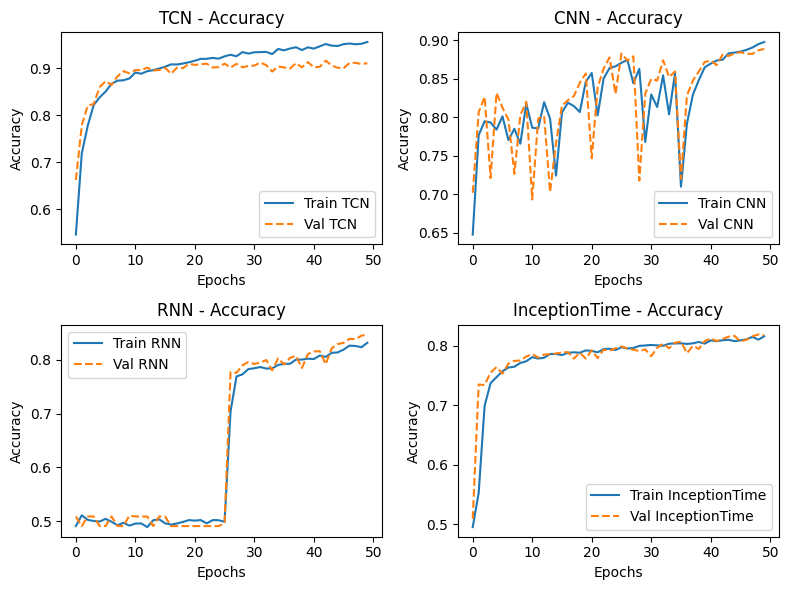

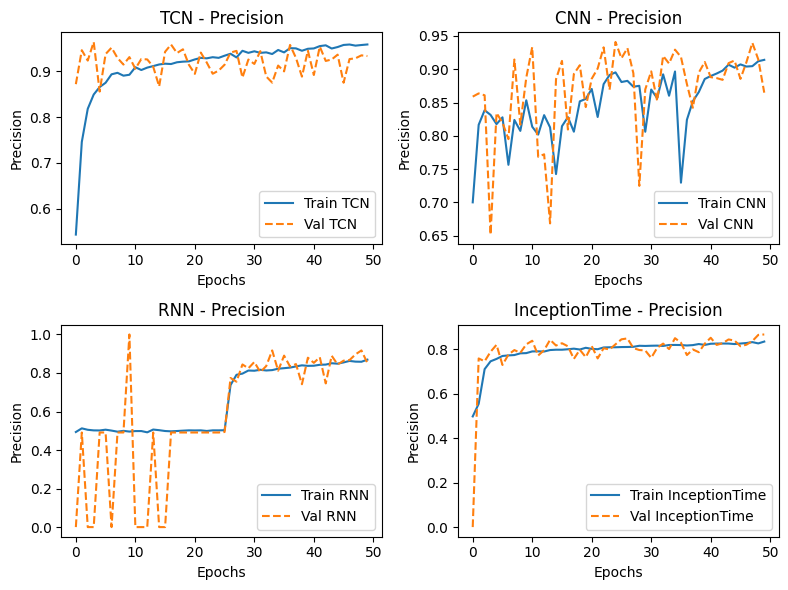

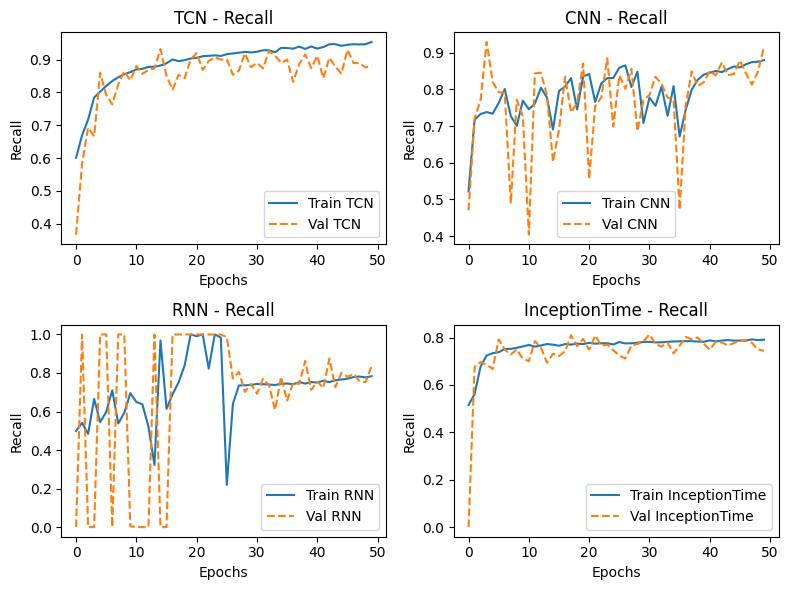

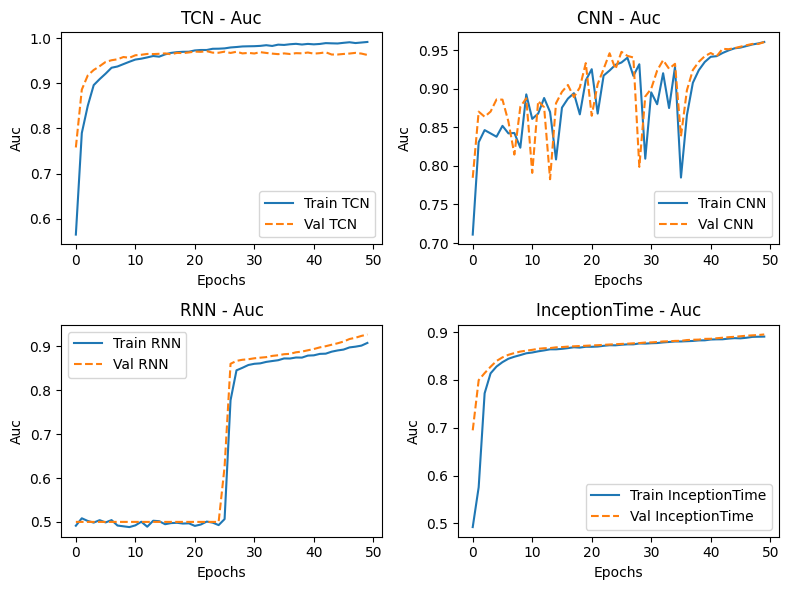

In [169]:
#compare model metrics
def compare_model_metrics(histories, labels):
   
    metrics = ['accuracy', 'precision', 'recall', 'auc']
    for metric in metrics:
        fig, axs = plt.subplots(2, 2, figsize=(8, 6))  
        axs = axs.flatten() 
        for i, (history, label) in enumerate(zip(histories, labels)):
            ax = axs[i]  
            ax.plot(history.history[metric], label=f'Train {label}')
            val_metric = f'val_{metric}'
            if val_metric in history.history:
                ax.plot(history.history[val_metric], label=f'Val {label}', linestyle="--")
            ax.set_title(f'{label} - {metric.capitalize()}')
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric.capitalize())
            ax.legend()
        plt.tight_layout() 
        plt.show()  

#histories = [CNNhistory, AdvancedCNNhistory]
histories = [TCNhistory, RNNhistory, CNNhistory, IThistory]
labels = ['TCN', 'CNN', 'RNN', 'InceptionTime']
compare_model_metrics(histories, labels)

69/69 [==============================] - 11s 153ms/step


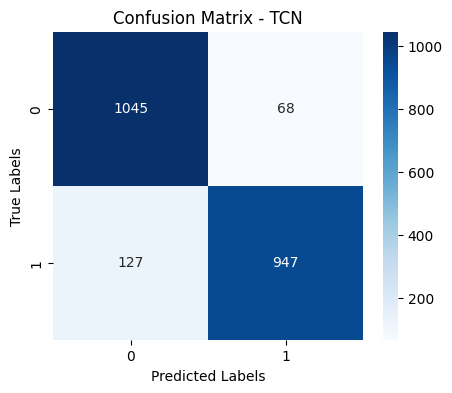

69/69 [==============================] - 11s 158ms/step


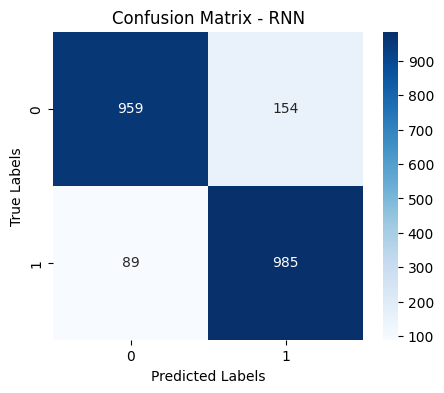

69/69 [==============================] - 1s 21ms/step


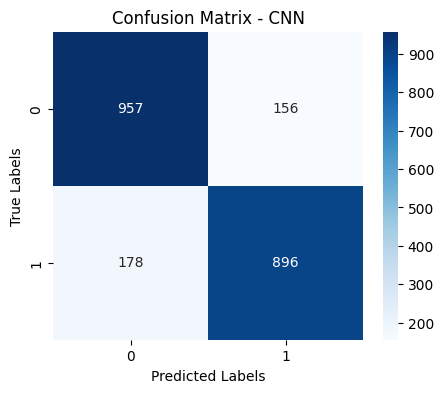

69/69 [==============================] - 1s 12ms/step


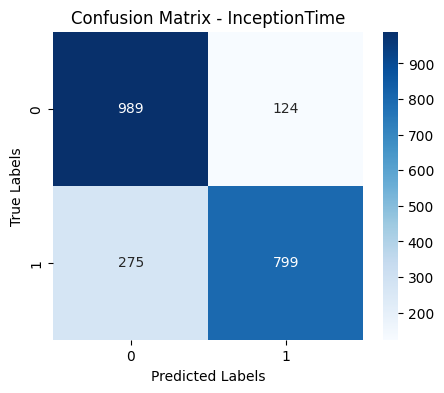

In [175]:
def plot_confusion_matrix(y_true, y_pred, label):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#models = [CNNmodel,AdvancedCNNmodel]  
models = [TCNmodel, RNNmodel, CNNmodel, ITmodel]  
model_labels = ['TCN', 'RNN', 'CNN', 'InceptionTime']

for model, label in zip(models, model_labels):
    with tf.device('/cpu:0'):
        y_pred = model.predict(X_test)
        y_pred_classes = (y_pred > 0.5).astype(int) 
        plot_confusion_matrix(Y_test, y_pred_classes, label)

In [172]:
from sklearn.metrics import f1_score
import numpy as np

def calculate_f1_score(model, X_test, y_test):
    with tf.device('/cpu:0'):
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        return f1_score(y_test, y_pred)

In [174]:
def create_metrics_table(histories, models, X_test, y_test, labels):
    metrics = {'Model': [], 'Accuracy': [], 'F1 Score': []}
    for history, model, label in zip(histories, models, labels):
        metrics['Model'].append(label)
        metrics['Accuracy'].append(history.history['val_accuracy'][-1])
        metrics['F1 Score'].append(calculate_f1_score(model, X_test, y_test))
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

# modelle und histories in a list
#models = [CNNmodel,AdvancedCNNhistory]
#histories = [CNNmodel, AdvancedCNNmodel]
models = [TCNmodel, RNNmodel, CNNmodel, ITmodel]
histories = [TCNhistory, RNNhistory, CNNhistory, IThistory]
labels = ['TCN', 'RNN', 'CNN', 'InceptionTime']
metrics_table = create_metrics_table(histories, models, X_test, Y_test, labels)
print(metrics_table)

69/69 [==============================] - 1s 11ms/step
           Model  Accuracy  F1 Score
0            TCN  0.910837  0.906654
1            RNN  0.888889  0.890194
2            CNN  0.847279  0.842897
3  InceptionTime  0.817558  0.800200


In [1]:
#safe the models check path
CNNmodel.save('C:\\Privat\\Universität\\MScHealthInformatics\\Sem4\\MasterThesis\\SavedModules\\Normal_MI_100hz_Model/\CNN_Modell.h5')
TCNmodel.save('C:\\Privat\\Universität\\MScHealthInformatics\\Sem4\\MasterThesis\\SavedModules\\Normal_MI_100hz_Model/\TCN_Modell.h5')
RNNmodel.save('C:\\Privat\\Universität\\MScHealthInformatics\\Sem4\\MasterThesis\\SavedModules\\Normal_MI_100hz_Model/\RNN_Modell.h5')
ITmodel.save('C:\\Privat\\Universität\\MScHealthInformatics\\Sem4\\MasterThesis\\SavedModules\\Normal_MI_100hz_Model/\InceptionTime_Modell.h5')

NameError: name 'CNNmodel' is not defined